In [1]:
import os
import time
import json
import random
from datetime import datetime
from dotenv import load_dotenv
from textwrap import dedent
from typing import Annotated, List, Literal, Optional, Callable
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, AnyMessage
from langchain_groq import ChatGroq
from IPython.display import Image, display
import sqlite3
from pydantic import BaseModel, Field
from langchain_core.messages import ToolMessage, AIMessage, trim_messages, HumanMessage
from langchain_core.tools import StructuredTool, ToolException, InjectedToolCallId
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from sentence_transformers import SentenceTransformer
from pinecone import Pinecone, ServerlessSpec
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig, RunnableLambda

/home/prince/anaconda3/envs/nexusEnv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv('../data/.env')

True

## Utils

In [3]:
def create_or_load_pinecone_index(index_name: str, embedding_dims: int) -> Pinecone.Index:
    """Creates or loads a Pinecone index."""
    pinecone_api_key = os.environ.get("PINECONE_API_KEY")
    pc = Pinecone(api_key=pinecone_api_key)

    if not pc.has_index(index_name):
        pc.create_index(
            name=index_name,
            dimension=embedding_dims,
            metric="cosine",
            spec=ServerlessSpec(
                cloud="aws",
                region="us-east-1"
            ),
        )
        while not pc.describe_index(index_name).status["ready"]:
            time.sleep(1)
    return pc.Index(index_name)

def load_embedding_model(model_name: str) -> SentenceTransformer:
    """Loads the embedding model."""
    model = SentenceTransformer(
        model_name,
        token=os.getenv('HF_API_KEY', None)
    )
    return model

def get_intents_from_query(query_text: str) -> List[str]:
    """Retrieves a list of intents from the SUPPORTED INTENTS from the given text."""
    intents = []
    for intent in SUPPORTED_INTENTS:
        if intent in query_text.lower():
            intents.append(intent)
    return intents

## Tools

In [4]:
DB_PATH = '../data/chatbot.db'
index_name = "policy-info-index"
top_k: int = 50
rerank_top_n: int = 5
score_threshold: float = 0.0
SUPPORTED_INTENTS = {
    "return", "refund", "exchange", "damaged item", "shipping", "payment", "replacement"
}

In [5]:
def get_similar_products_for_order(order_id: int) -> List[str]:
    """
    Retrieves a list of similar products by given order ID. Use this tool only if the user
    asks for a product recommendation. It checks for the same product category,
    size and gender(or unisex).

    Args:
        order_id: The 5-digit order ID.

    Returns:
        A list of similar product names.

    Raises:
        ToolException: If no similar products are found or order_id is invalid.
    """
    try:
        similar_products = []
        if (not isinstance(order_id, int)) or (not (10000 <= order_id <= 99999)):
          raise ToolException("Order ID must be a five-digit number.")
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()

            # Get product category, gender, and size for the given order ID
            cursor.execute("""
                SELECT product_category, gender, size
                FROM orders
                WHERE order_id = ?
            """, (order_id,))

            result = cursor.fetchone()

            if result:
                product_category, gender, size = result

                # Find similar products based on gender, category, and size
                cursor.execute("""
                    SELECT product_name
                    FROM orders
                    WHERE ((gender = ? OR lower(gender) = 'unisex')
                        AND product_category = ?
                        AND size = ?
                        AND order_id != ? )
                    ORDER BY quantity DESC
                    LIMIT 3
                """, (gender, product_category, size, order_id))

                similar_products = [row[0] for row in cursor.fetchall()]

        if len(similar_products) == 0:
            raise ToolException("No similar products found for this order ID.")
        # else:
        #     similar_products = '* '+'\n* '.join(similar_products)
    except Exception as ex:
        raise ToolException(str(ex))
    return similar_products

In [6]:
get_similar_products_for_order(88562)

['Running Sneakers']

In [7]:
product_recommendor_tool = StructuredTool.from_function(
    func=get_similar_products_for_order,
    name="Product-Recommendor-By-OrderID",
    return_direct=True,
    parse_docstring=True,
    handle_tool_error=True
)

In [8]:
def generate_return_authorization(order_id: int) -> str:
    """Generates a return authorization number for the given order ID if user asks to return an order

    Args:
        order_id: The five-digit order ID.

    Returns:
        The generated return authorization number.

    Raises:
        ToolException: If the order ID is not a five-digit number.
    """
    if not (10000 <= order_id <= 99999):
        raise ToolException("Order ID must be a five-digit number.")

    # Use the order ID to seed the random number generator for deterministic behavior
    random.seed(order_id)
    random_number = random.randint(10000, 99999)
    return f"RA{random_number}"

In [9]:
generate_return_authorization(89372)

'RA33161'

In [10]:
return_auth_generator_tool = StructuredTool.from_function(
    func=generate_return_authorization,
    name="Generate-Return-Authorization",
    return_direct=True,
    parse_docstring=True,
    handle_tool_error=True
)

In [11]:
return_auth_generator_tool.invoke(
    {'order_id': 89372}
)

'RA33161'

In [12]:
def get_order_details(order_id: int) -> dict:
    """
    Fetches order details from the database given the order ID.

    Args:
        order_id: The 5-digit order ID of the order to retrieve.

    Returns:
        A dictionary containing the order details as key values.

    Raises:
        ToolException: If no order is found with the given order_id or order_id is invalid.
    """
    try:
        if (not isinstance(order_id, int)) or (not (10000 <= order_id <= 99999)):
            raise ToolException("Order ID must be a five-digit number.")
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            cursor.execute("""
                SELECT
                    order_id, product_category, product_name, size, quantity, `price_(usd)`,
                    order_date, status, payment_method, shipping_address, final_sale
                FROM orders
                WHERE order_id = ?
            """, (order_id,))

            result = cursor.fetchone()

            if result is None:
                raise ToolException(f"No order found with ID: {order_id}")

            order_details = {
                "order_id": result[0],
                "product_category": result[1],
                "product_name": result[2],
                "size": result[3],
                "quantity": result[4],
                "price_(usd)": result[5],
                "order_date": datetime.strptime(result[6], '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d'),  # Format date
                "status": result[7],
                "payment_method": result[8],
                "shipping_address": result[9],
                "final_sale": result[10]
            }
            # return json.dumps(order_details)
            return order_details

    except sqlite3.Error as ex:
        raise ToolException(f"Database error: {ex}")
    except Exception as ex:
        raise ToolException(str(ex))

In [13]:
print(get_order_details(88562))

{'order_id': 88562, 'product_category': 'Casual Shoes', 'product_name': 'Slip-On Sneakers', 'size': 9, 'quantity': 1, 'price_(usd)': 54.99, 'order_date': '2025-01-29', 'status': 'Delivered', 'payment_method': 'Credit Card', 'shipping_address': 'OH, USA', 'final_sale': 'No'}


In [14]:
get_order_details_tool = StructuredTool.from_function(
    func=get_order_details,
    name="Get-Order-Details",
    return_direct=True,
    parse_docstring=True,
    handle_tool_error=True
)

In [15]:
pc = Pinecone(os.getenv("PINECONE_API_KEY"))
pc_index = create_or_load_pinecone_index(index_name, embedding_dims=768)
embedding_model = load_embedding_model('sentence-transformers/all-mpnet-base-v2')

In [16]:
def retrieve_relevant_policies_by_query(query_text: str) -> List[str]:
    """Retrieves the most relevant policies from the vector store for the given user query.
    The policies are ranked as per their relevance with the given user query.

    Args:
        query_text: The user's query string.

    Returns:
        A list of the most relevant policies for the given query.

    Raises:
        ToolException: If any error occurs during the process.
    """
    try:
        # Search Pinecone index
        query_intents = get_intents_from_query(query_text)
        query_response = pc_index.query(
            vector=embedding_model.encode(query_text).tolist(),
            top_k=top_k,
            include_metadata=True,
            include_values=False,
            filter={
                "intents": {
                    "$in": query_intents
                }
            } if len(query_intents) > 0 else None
        )

        # Prepare policies for reranking
        policies = [
            {"id": x["id"], "text": x["metadata"]["text"]}
            for x in query_response["matches"]
        ]

        # Rerank policies
        reranked_policies = pc.inference.rerank(
            model="bge-reranker-v2-m3",
            query=query_text,
            documents=policies,
            top_n=rerank_top_n,
            return_documents=True,
        )

        # Filter out low-scoring policies
        filtered_policies = [
            doc.document.text for doc in reranked_policies.rerank_result.data \
                if doc["score"] >= score_threshold
        ]
        # filtered_policies = '* '+'\n* '.join(filtered_policies)
        return filtered_policies

    except Exception as ex:
        raise ToolException(str(ex))

In [17]:
query_text = 'what is the process for damaged items?'
similar_policies = retrieve_relevant_policies_by_query(query_text)
print(similar_policies)

['damaged or defective items should be reported within 7 days of delivery.', 'the company may request the return of the damaged item before issuing a refund or replacement.', 'photos of the damage are required when reporting the issue.', 'a replacement will be sent free of charge or a full refund will be issued.']


In [18]:
get_relevant_policies_by_query_tool = StructuredTool.from_function(
    func=retrieve_relevant_policies_by_query,
    name="Get-Relevant-Policies-By-Query",
    return_direct=True,
    parse_docstring=True,
    handle_tool_error=True
)

In [19]:
def days_since_date(date_str: str) -> int:
    """Calculates the number of days passed since the given order date.

    Args:
        date_str: The date string in YYYY-MM-DD format.

    Returns:
        The number of days passed since the given order date.

    Raises:
        ToolException: If the date string is not in the correct format or if there's an error during date processing.
    """
    try:
        date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        today = datetime.now()
        delta = today - date_obj
        return delta.days
    except ValueError:
        raise ToolException("Incorrect date format. Please use YYYY-MM-DD.")
    except Exception as e:
        raise ToolException(f"An error occurred: {e}")

In [20]:
days_since_date('2025-03-01')

10

In [21]:
days_since_date_tool = StructuredTool.from_function(
    func=days_since_date,
    name="Days-Since-Date",
    return_direct=True,
    parse_docstring=True,
    handle_tool_error=True
)

In [22]:
print(days_since_date_tool.name)
print(days_since_date_tool.description)
print(days_since_date_tool.args)

Days-Since-Date
Calculates the number of days passed since the given order date.
{'date_str': {'description': 'The date string in YYYY-MM-DD format.', 'title': 'Date Str', 'type': 'string'}}


## Start

In [23]:
def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [24]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [25]:
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [26]:
llm = ChatGroq(
    # model='gemma2-9b-it',
    model='llama3-70b-8192',
    temperature=0.3,
    max_tokens=256,
    api_key=os.getenv('GROQ_API_KEY')
)

In [27]:
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            dedent("""\
            You are a specialised customer support assistant chatbot for a footwear business. You MUST only answer questions related to business.

            ## DECISION MAKING RULES

            Follow the below rules very strictly for doing your job:
                1. You MUST ALWAYS answer query using only the information provided by your tools.
                2. If the user is asking for some process related information, use the tool and user query to fetch the policy information, and return the result. Ex - what is the return policy?
                3. If the user is asking to perform any action given any specific order Id, use the tools to fetch both order details and policy details. Ex - i want to return my order 45673
                4. In case of any exchange, return or refund be very careful about policy rules and make sure they are not violated. Ex - sale items, days passed since order, etc.
                5. While checking eligibility for return/exchange etc. be careful about all the policy rules applicable. Always use tool to calculate days passed since order date.
                6. In case user is asking for product recommendation just use the order Id and the required tool.
                7. If the user is sure to return the product, first check eligibility, then call the tool to generate request authorization number and send it back to the user.
                8. Do not create or assume any information. Use the information provided by the tools ONLY. If you cannot answer say you cannot.
                9. The final answer should be very crisp and to the point in max 2-3 sentences. It also should be conversational and human-like.
                10. Don't refer the user to chatbot. You are the chatbot and should do the job.
            
            ## END OF RULES
            """)
        ),
        ("placeholder", "{messages}"),
    ]
)


In [28]:
print(primary_assistant_prompt.messages[0].prompt.template)

You are a specialised customer support assistant chatbot for a footwear business. You MUST only answer questions related to business.

## DECISION MAKING RULES

Follow the below rules very strictly for doing your job:
    1. You MUST ALWAYS answer query using only the information provided by your tools.
    2. If the user is asking for some process related information, use the tool and user query to fetch the policy information, and return the result. Ex - what is the return policy?
    3. If the user is asking to perform any action given any specific order Id, use the tools to fetch both order details and policy details. Ex - i want to return my order 45673
    4. In case of any exchange, return or refund be very careful about policy rules and make sure they are not violated. Ex - sale items, days passed since order, etc.
    5. While checking eligibility for return/exchange etc. be careful about all the policy rules applicable. Always use tool to calculate days passed since order dat

In [29]:
primary_assistant_safe_tools = [
    get_order_details_tool,
    get_relevant_policies_by_query_tool,
    days_since_date_tool,
    product_recommendor_tool,
]

primary_assistant_sensitive_tools = [
    return_auth_generator_tool,
]

primary_assistant_tools = primary_assistant_safe_tools + primary_assistant_sensitive_tools

In [30]:
primary_assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
)

In [31]:
builder = StateGraph(State)

In [32]:
# Define nodes and edges: these do the work
builder.add_node("assistant", Assistant(primary_assistant_runnable))
builder.add_node(
    "safe_tools", create_tool_node_with_fallback(primary_assistant_safe_tools)
)
builder.add_node(
    "sensitive_tools", create_tool_node_with_fallback(primary_assistant_sensitive_tools)
)
builder.add_edge(START, "assistant")

In [33]:
def route_tools(state: State):
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    sensitive_tool_names = {t.name for t in primary_assistant_sensitive_tools}
    if first_tool_call["name"] in sensitive_tool_names:
        return "sensitive_tools"
    return "safe_tools"

In [34]:
builder.add_conditional_edges(
    "assistant", route_tools, ["safe_tools", "sensitive_tools", END]
)
builder.add_edge("safe_tools", "assistant")
builder.add_edge("sensitive_tools", "assistant")

In [35]:
# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
graph = builder.compile(
    checkpointer=memory,
    interrupt_before=["sensitive_tools"]
)

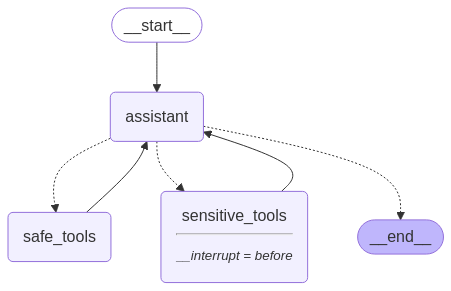

In [36]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as ex:
    # This requires some extra dependencies and is optional
    print(ex)
    pass

In [ ]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "what is the policy information regarding the return process?",
    "who is the prime minister of india?",
    "can you give me the details of order 50570?",
    "I want to exchage my order 50570",
    "i want to know about the return policy for damaged items",
    "I want to exchange my running shoes with casual ones.",
    "I want to know the process of refund",
    "I want to return my order 89694",
    "my order number is 88562. Can you recommend another product for me?",
    "can you tell me when was shahrukh khan born?",
    "i want to return order 43973?"
]


In [ ]:
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    },
    # "recursion_limit": 3
}


In [ ]:
_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    # result = graph.invoke(
    #     {"messages": [("user", question)]},
    #     config
    # )
    snapshot = graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        # if user_input.strip() == "y":
        if user_input.strip().startswith("yes"):
            # Just continue
            result = graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"Tool call denied by user. Reasoning: '{user_input}'. Ask user for product recommendation.",
                        )
                    ]
                },
                config,
            )
        snapshot = graph.get_state(config)

    snapshot.values['messages'] = trim_messages(
        snapshot.values['messages'],
        strategy="last",
        token_counter=llm,
        max_tokens=1024,
        start_on="human",
        end_on=("human", "tool"),
        include_system=True,
    )

In [39]:
import gradio as gr
import time


# Function to handle synchronous responses with a typing effect
def sync_chatbot_response(message, history):
    try:
        response = graph.invoke({
            "messages": [("user", message)]
        }, config)['messages'][-1].content

        history.append((f"👤 {message}", ""))  # Append user message
        for i in range(len(response)):
            time.sleep(0.02)  # Typing effect delay
            history[-1] = (f"👤 {message}", f"🤖 {response[:i+1]}")
            yield history, ""
    except Exception as e:
        print(f"Sync Error: {e}")
        history.append((f"👤 {message}", f"⚠️ Error: {str(e)}"))
        yield history, ""

# Gradio UI with a fixed chat window width
with gr.Blocks(css="""
    body {background-color: #f8f9fa; font-family: 'Arial', sans-serif;}
    .gradio-container {max-width: 700px; margin: auto; text-align: center;}  /* Centering everything */
    #chatbot {border-radius: 10px; background: white; box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.1);
              width: 100%; min-height: 450px; max-width: 700px; margin: auto;} /* Fixed width from start */
    .message-box {width: 100%;} /* Fix input width */
""") as demo:

    gr.Markdown("## 👟 **SoleMate – Your Footwear Assistant**", elem_id="banner")

    chatbot = gr.Chatbot(elem_id="chatbot", height=450, bubble_full_width=False)

    msg = gr.Textbox(placeholder="👋 Ask me about returns, exchanges, or orders...", label="", elem_classes="message-box")

    send_btn = gr.Button("🚀 Send")

    # Sync response handler with message clearing
    send_btn.click(sync_chatbot_response, inputs=[msg, chatbot], outputs=[chatbot, msg], queue=True)
    msg.submit(sync_chatbot_response, inputs=[msg, chatbot], outputs=[chatbot, msg], queue=True)

# Launch the UI
demo.launch(share=True)

/tmp/ipykernel_37777/4272001211.py:33: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(elem_id="chatbot", height=450, bubble_full_width=False)
/tmp/ipykernel_37777/4272001211.py:33: DeprecationWarning: The 'bubble_full_width' parameter is deprecated and will be removed in a future version. This parameter no longer has any effect.
  chatbot = gr.Chatbot(elem_id="chatbot", height=450, bubble_full_width=False)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://6164508639d2b4bd64.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
